# Procrustes analysis of PFC tuning across development

Each task analysed independently (all its monkeys).

**3 tasks:** ODR 1.5s (8 monkeys), ODR 3.0s (4 monkeys), ODRd 20 conditions (4 monkeys)

**Pipeline:** Load data → PSTHs → tuning curves → age groups → PCA + Procrustes → statistics → temporal analysis

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
sys.path.insert(0, '.')

from functions import (
    load_all_task_data,
    compute_flat_tuning,
    build_representations, procrustes_distance_matrix,
    assign_age_groups, cross_monkey_analysis, cross_age_analysis,
    extract_entry_arrays, load_behavioral_perf,
    perf_vs_within_monkey_pairs, perf_vs_cross_monkey,
    rates_to_psth, temporal_cross_monkey, temporal_cross_age,
    plot_cross_monkey, plot_distance_matrices, plot_cross_age,
    plot_temporal, plot_age_decoding, plot_correlation_panels,
)

DATA_DIR     = '../data_raw'
N_AGE_GROUPS = 5
N_PCS        = 8
MIN_NEURONS  = N_PCS + 1
BIN_MS       = 50
WINDOW_MS    = 500
STEP_MS      = 50
N_BOOT       = 1000

ODR15_EPOCHS = {'cue': (0, 500), 'delay': (500, 2000), 'response': (2000, 2500)}
ODR30_EPOCHS = {'cue': (0, 500), 'delay': (500, 3000), 'response': (3000, 3500)}
ODRD_EPOCHS  = {'cue': (0, 500), 'delay': (500, 1700), 'distractor': (1700, 2200), 'response': (3000, 3500)}

## 1. Load data

In [ ]:
task_data = load_all_task_data(DATA_DIR)

for name, T in task_data.items():
    print(f'{name}: {T["data"].shape[0]} neurons, monkeys: {sorted(set(T["ids"]))}')

## 2. Compute PSTHs and tuning curves

In [ ]:
TASK_EPOCHS = {
    'ODR 1.5s': dict(t_range=(-1000, 2500), epochs=ODR15_EPOCHS),
    'ODR 3.0s': dict(t_range=(-1000, 3500), epochs=ODR30_EPOCHS),
    'ODRd':     dict(t_range=(-1000, 4000), epochs=ODRD_EPOCHS),
}

psth_data = {}
for name, cfg in TASK_EPOCHS.items():
    flat, rates, bc = compute_flat_tuning(task_data[name]['data'], cfg['t_range'], cfg['epochs'], BIN_MS)
    psth_data[name] = dict(rates=rates, bc=bc, flat=flat)
    print(f'{name}: {flat.shape}')

## 3. Age groups, PCA, Procrustes, and statistics

In [ ]:
results = {}
for task_name in task_data:
    ids = task_data[task_name]['ids']
    abs_age = task_data[task_name]['abs_age']
    tuning = psth_data[task_name]['flat']

    ag = assign_age_groups(ids, abs_age, N_AGE_GROUPS)
    entries = build_representations(tuning, ids, ag,
                                    n_pcs=N_PCS, min_neurons=MIN_NEURONS, zscore=True)
    dist = procrustes_distance_matrix(entries)
    labels = [f"{e['monkey']}_G{e['group']}" for e in entries]

    cm = cross_monkey_analysis(entries, dist)
    ca = cross_age_analysis(entries, dist)

    results[task_name] = dict(
        entries=entries, dist=dist, labels=labels, age_group=ag,
        cross_monkey=cm, cross_age=ca,
    )
    print(f'{task_name}: {len(entries)} entries, '
          f'cross>within t={cm["t_stat"]:.2f} p={cm["p_val"]:.4f}, '
          f'identity>age t={ca["t_stat"]:.2f} p={ca["p_val"]:.4f}')

## 4. Cross-monkey analysis

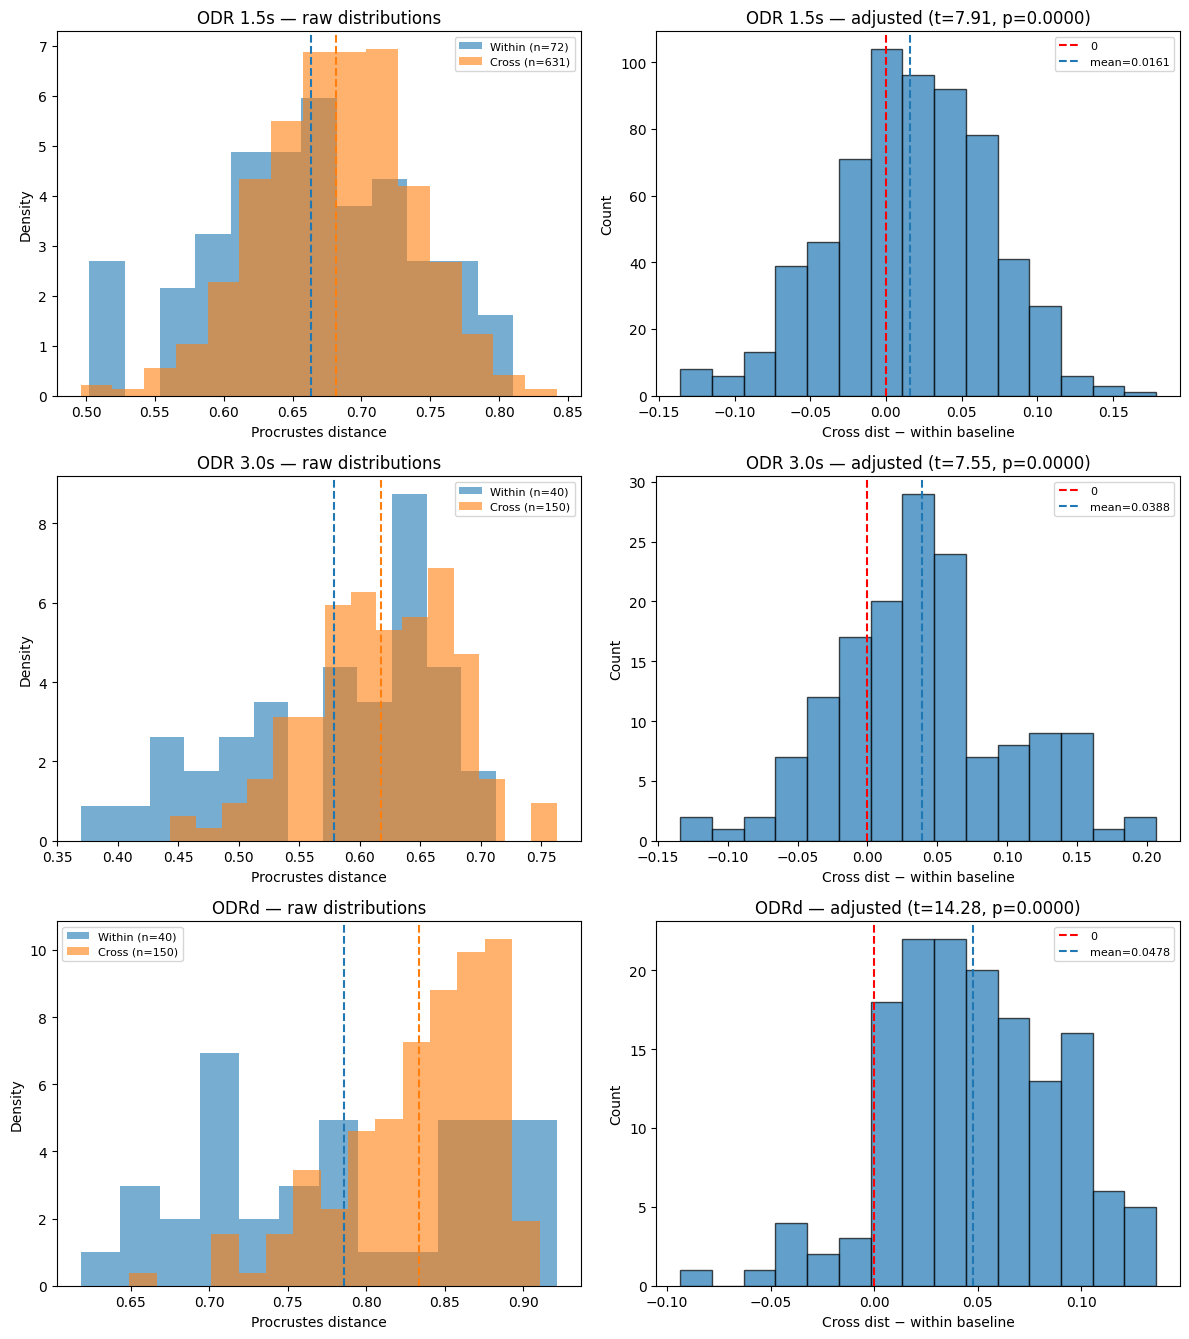

In [76]:
plot_cross_monkey(results)

## 5. Distance matrices

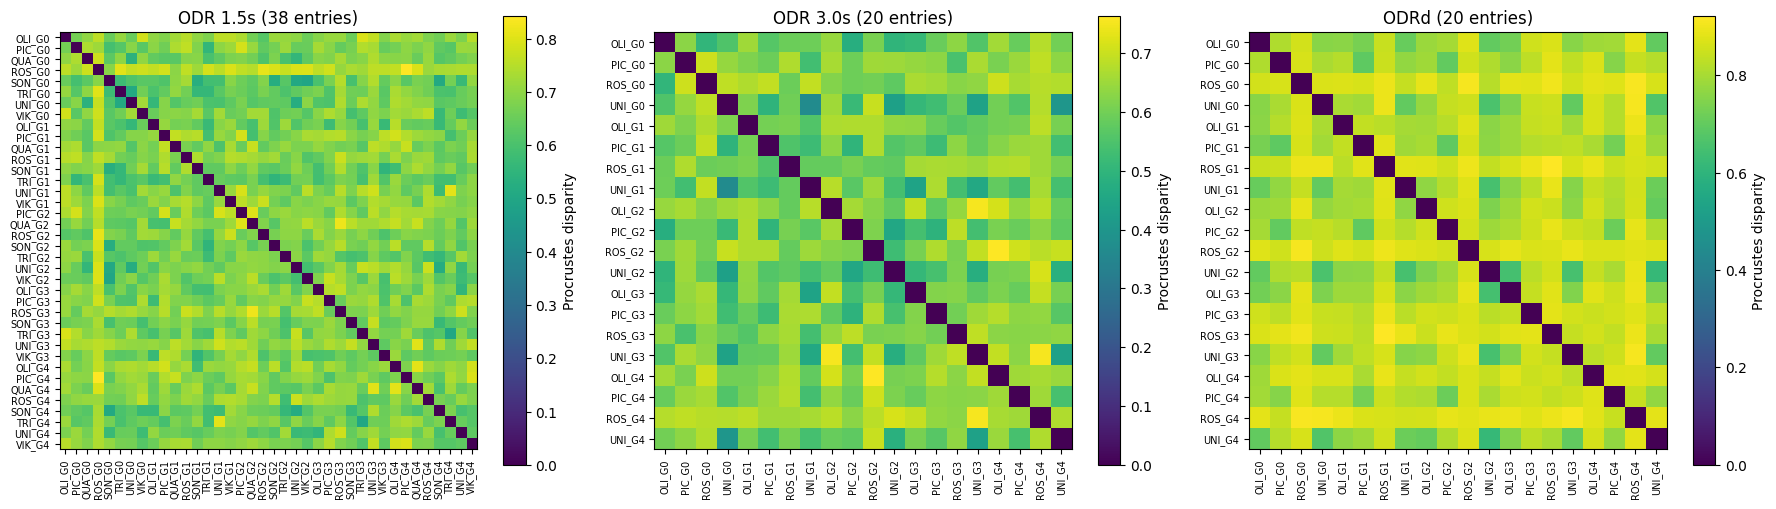

In [77]:
plot_distance_matrices(results)

## 6. Cross-age analysis

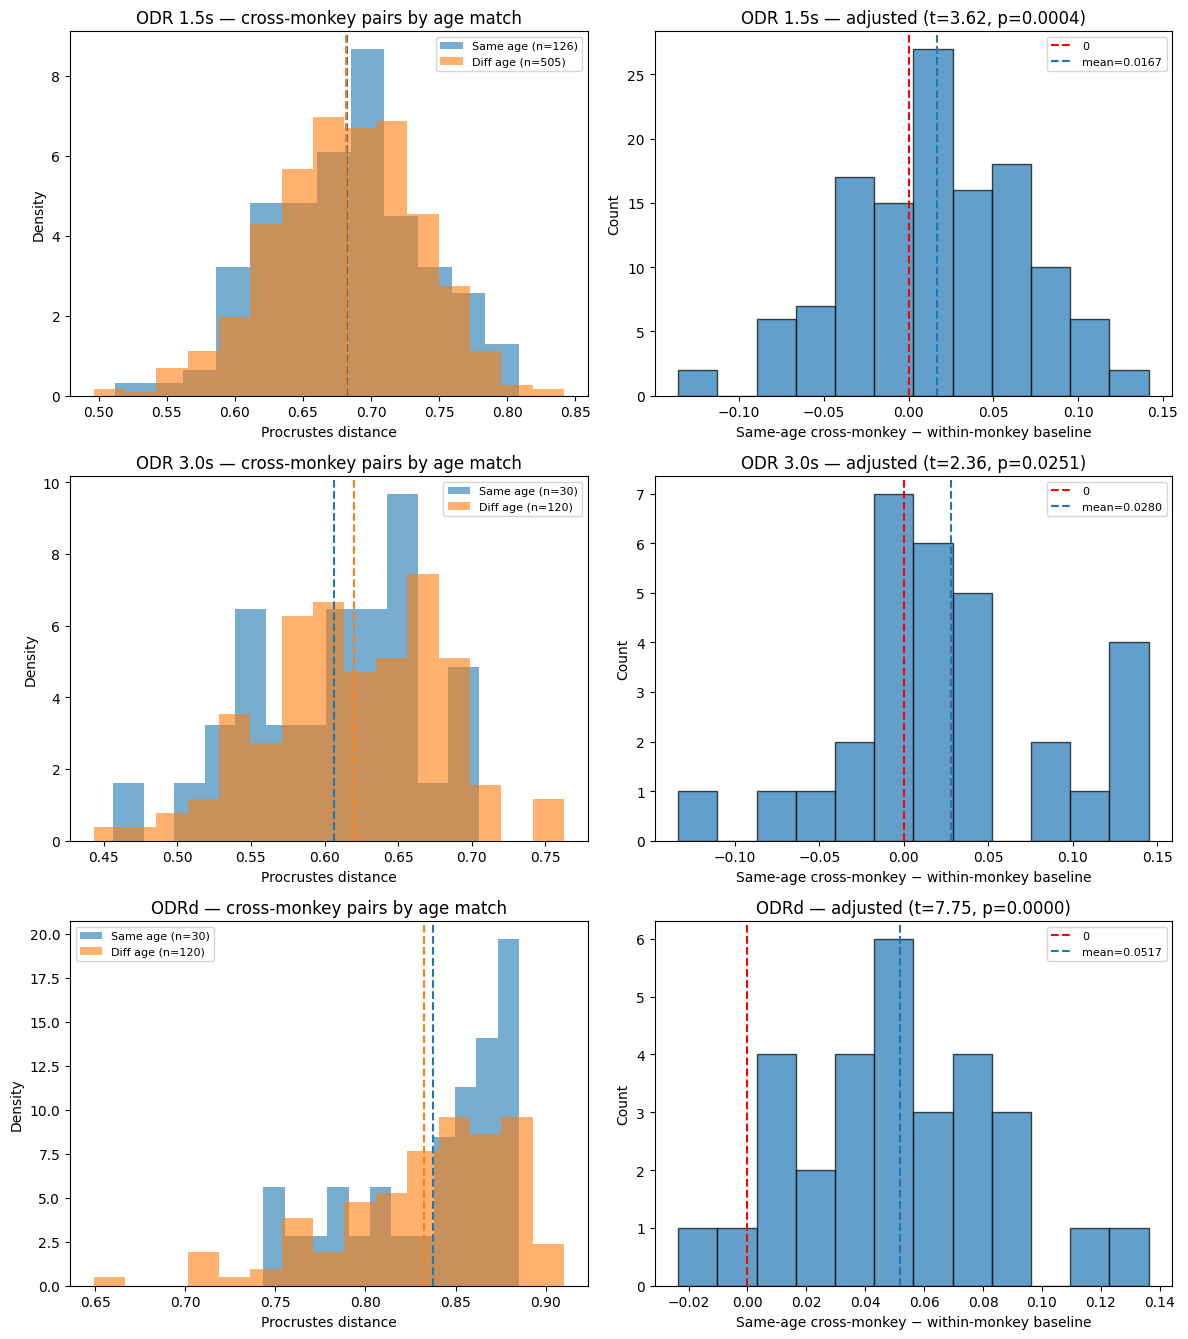

In [78]:
plot_cross_age(results)

## 6b. Age decoding from distance matrices

In [ ]:
plot_age_decoding(results, k=3)

## 6c. Behavioral performance vs Procrustes geometry

In [ ]:
task_metadata = {name: (task_data[name]['ids'], task_data[name]['abs_age']) for name in task_data}

perf_by_entry = load_behavioral_perf(
    os.path.join('..', 'behavior', 'beh_data.csv'),
    os.path.join('..', 'behavior', 'performance_odrd.csv'),
    task_metadata,
    N_AGE_GROUPS)

scatter = perf_vs_within_monkey_pairs(results, perf_by_entry)
plot_correlation_panels(scatter, '|Δ performance| (percent correct)',
                        'Within-monkey Procrustes distance')

In [ ]:
scatter = perf_vs_cross_monkey(results, perf_by_entry, N_AGE_GROUPS)
plot_correlation_panels(scatter, '|Δ mean performance|', 'Mean cross-monkey Procrustes distance',
                        suptitle='Cross-monkey geometry vs performance (averaged over age)')

## 7. Temporal cross-monkey distances

### 7.1 All monkeys

In [ ]:
psths = {name: rates_to_psth(psth_data[name]['rates']) for name in psth_data}

temporal_monkey = {}
for name in task_data:
    ids = task_data[name]['ids']
    t, boots = temporal_cross_monkey(psths[name], psth_data[name]['bc'], ids,
                                     results[name]['age_group'],
                                     n_pcs=N_PCS, min_neurons=MIN_NEURONS,
                                     window_ms=WINDOW_MS, step_ms=STEP_MS, n_boot=N_BOOT)
    temporal_monkey[name] = dict(t=t, boots=boots)
    print(f'{name}: {len(t)} time points')

plot_temporal(temporal_monkey,
              ylabel='Mean cross-monkey Procrustes distance',
              title=f'Cross-monkey distance over time ({WINDOW_MS} ms window, {STEP_MS} ms step, ±SE)')

### 7.2 Common monkeys only (OLI, PIC, ROS, UNI)

In [ ]:
common_monkeys = sorted(
    set(task_data['ODR 1.5s']['ids']) &
    set(task_data['ODR 3.0s']['ids']) &
    set(task_data['ODRd']['ids'])
)
print(f'Common monkeys: {common_monkeys}')

temporal_monkey_common = {}
for name in task_data:
    ids = task_data[name]['ids']
    mask = np.isin(ids, common_monkeys)
    t, boots = temporal_cross_monkey(psths[name][mask], psth_data[name]['bc'], ids[mask],
                                     results[name]['age_group'][mask],
                                     n_pcs=N_PCS, min_neurons=MIN_NEURONS,
                                     window_ms=WINDOW_MS, step_ms=STEP_MS, n_boot=N_BOOT)
    temporal_monkey_common[name] = dict(t=t, boots=boots)
    print(f'{name}: {mask.sum()} neurons, {len(t)} time points')

plot_temporal(temporal_monkey_common,
              ylabel='Mean cross-monkey Procrustes distance',
              title=f'Cross-monkey distance (common monkeys) ({WINDOW_MS} ms window, {STEP_MS} ms step, ±SE)')

## 8. Temporal cross-age distances

In [ ]:
temporal_age = {}
for name in task_data:
    ids = task_data[name]['ids']
    t, boots = temporal_cross_age(psths[name], psth_data[name]['bc'], ids,
                                  results[name]['age_group'],
                                  n_pcs=N_PCS, min_neurons=MIN_NEURONS,
                                  window_ms=WINDOW_MS, step_ms=STEP_MS, n_boot=N_BOOT)
    temporal_age[name] = dict(t=t, boots=boots)
    print(f'{name}: {len(t)} time points')

plot_temporal(temporal_age,
              ylabel='Mean cross-age Procrustes distance',
              title=f'Cross-age (within-monkey) distance over time ({WINDOW_MS} ms window, {STEP_MS} ms step, ±SE)')